In [1]:
#Import module
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
import scipy.optimize as optimization  
import pandas as pd
#Latex font
import matplotlib as mpl
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=16)

In [2]:
ls

2022_Feb_week4_Linear_fit_period.dat
2022_Feb_week4_Linear_fit_period_Boyd.dat
2022_Feb_week4_Linear_fit_period_This_work.dat
2022_Feb_week4_OC_diagram.jpg
2022_Feb_week4_OC_diagram.out
2022_Feb_week4_Weighted_mean_calculation_Beuermann_2011_combined.out
2022_Feb_week4_Weighted_mean_calculation_This_work_combined.out
2022_Feb_week4_Weighted_mean_calculation_This_work_combined_Boyd.out
2022_Feb_week4_Weighted_mean_calculation_This_work_combined_rev1.out
2022_Feb_week4_new_ephemeris_LTT_fit.jpg
2022_Feb_week4_new_ephemeris_LTT_fit_Beuermann_2011.jpg
DPLeo.txt
DP_Leo_LTT_fit.ipynb
DP_Leo_LTT_fit_Beuermann_2011.ipynb
DP_Leo_LTT_fit_Beuermann_2011_Res.jpg
DP_Leo_LTT_fit_Boyd.ipynb
DP_Leo_LTT_fit_Boyd_Res.jpg
DP_Leo_LTT_fit_Demo.ipynb
DP_Leo_LTT_fit_Demo.jpg
DP_Leo_LTT_fit_Demo1.ipynb
DP_Leo_LTT_fit_Demo1.jpg
DP_Leo_LTT_fit_Demo1_Res.jpg
DP_Leo_LTT_fit_Demo2.ipynb
DP_Leo_LTT_fit_Demo2_Res.jpg
DP_Leo_LTT_fit_Demo3.ipynb
DP_Leo_LTT_fit_Demo_Beuermann_2011.ipynb
DP_Leo_LTT_fit_Demo_Res.jpg
DP_L

In [3]:
#Read data ---#1
Input = "2022_Feb_week4_Weighted_mean_calculation_This_work_combined_rev1.out"
Data   = np.genfromtxt(Input)

BJD_time = Data[:,0]
OC = Data[:,1]
OC_err = Data[:,2]

In [4]:
#t = T0_bjd + P0_day*Epoch
x = BJD_time
y = OC
dy = OC_err

len_x = len(x)
#print(len_x)
#print(x)

In [5]:
K = 33.7        #m/s
P = 10220       #days
e = 0.39               #No-unit
w = -1.36           #rad
tau = 53025     #days

In [6]:
from scipy.optimize import fsolve
from scipy.optimize import curve_fit

In [7]:
def TAno(P,tau,e,t):
    MAno = 2*np.pi/P*((t-tau)%P)
    EFunc = lambda x: x-e*np.sin(x)-MAno
    EAno = fsolve(EFunc, MAno)
    f = np.arccos((np.cos(EAno)-e)/(1-e*np.cos(EAno)))
    f = np.where(EAno>np.pi,-f,f)
    return f

In [8]:
def keplerian_fit(t,K,P,e,w,tau):
    f = TAno(P,tau,e,t)
    return K*((1-e*e)/(1+e*np.cos(f))*np.sin(f+w))

In [9]:
import scipy.optimize as optimization  
guess = (K,P,e,w,tau)
params, params_covariance = optimization.curve_fit(keplerian_fit, x, y,sigma=dy, absolute_sigma=True,p0=guess)

K = params[0]
P = params[1]
e = params[2]
w = params[3]
tau = params[4]

dK = params_covariance[0,0]
dP = params_covariance[1,1]
de = params_covariance[2,2]
dw = params_covariance[3,3]
dtau = params_covariance[4,4]


ocfit = keplerian_fit(x,K,P,e,w,tau)
#print(ocfit)


if e<0:
    w -= np.pi
    e *= -1
    w_deg = w*180/np.pi
#    print(K,P,e,w,w_deg,tau)


#Semi-major axis calculation
P_yr = P/365.25              # period in years
a_au = (P_yr**2)**(1./3)     # semi-major axis in au
#print(a_au)
da_au =np.sqrt((2*dP/(3*P))**2)*a_au
#print(da_au)

#Semi-amplitude calculation
K_auyr = K*2.1096256684e-4
#print(K_auyr)
    
mp = (2*np.pi)**(-1)*K_auyr*np.sqrt(1-e**2)*(2*P_yr)**(1/3)
mp_mjup = mp*1047.59421
#print(mp_mjup)
dmp_mjup = mp_mjup * np.sqrt((dK/K)**2 + (dP/(3*P))**2 + (e*de/np.sqrt(1-e*e))**2 )
#print(dmp_mjup)

print("The Keplerian parameters:")
print("K =", K, "+/-", dK**0.5, "[m/s]")
print("P_d =", P, "+/-", dP**0.5, "[days]")
print("P_yr =", P/365.25, "+/-", (dP**0.5)/365.25, "[years]")
print("e =", e, "+/-", de**0.5, "[-]")
print("w =", w, "+/-", dw**0.5, "[rad]")
print("w_deg =", w*(180/np.pi), "+/-", dw**0.5*(180/np.pi), "[deg]")
print("tau =", tau, "+/-", dtau**0.5, "[days]")
#print ('a=', a_au ,'+/-', da_au, '[AU]')
#print ('Mpsin(i)=', mp_mjup ,'+/-', dmp_mjup, '[MJ]')



The Keplerian parameters:
K = 46.9534464445589 +/- 1.7532225268065227 [m/s]
P_d = 12108.954529161923 +/- 504.3872250065084 [days]
P_yr = 33.15251068901279 +/- 1.3809369610034452 [years]
e = 0.26570447824689 +/- 0.1326287487910615 [-]
w = -3.5592624712402787 +/- 0.23433684729158707 [rad]
w_deg = -203.93071778137153 +/- 13.426512334209615 [deg]
tau = 55087.199266548276 +/- 563.2500189304383 [days]


In [10]:
x_min, x_max = np.amin(x), np.amax(x)
x_line = np.linspace(x_min, x_max)
y_line = keplerian_fit(x_line, *params) #### For all interporation 
#print(y)
#print(ocfit)
#print(x)

#Reduced_chisqrt
m = 5
dof = len_x - m
Chi_sqr = ((y - ocfit)**2/(dy)**2)/dof
Reduced_chisq = sum(Chi_sqr)
print("Reduced_chisq:",Reduced_chisq)

Reduced_chisq: 0.4392139367698672


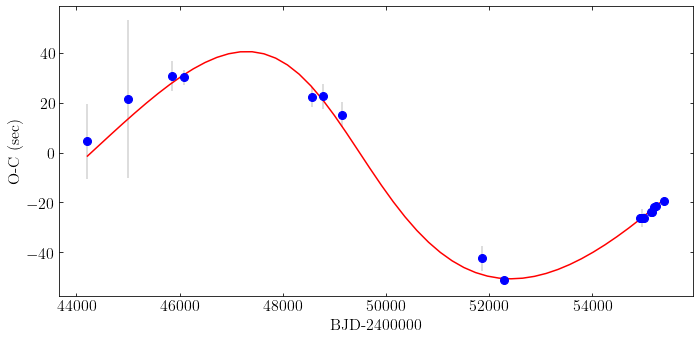

In [11]:
#print(phase)
#fig,ax = plt.subplots()
fig=plt.figure(figsize=(10, 5), tight_layout=True)
plt.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')
#plt.errorbar(x,y,dy,fmt='ok')
plt.errorbar(x, y, yerr= dy, fmt='o', markersize=8, color='blue', ecolor='lightgray')
plt.plot(x_line,y_line,'-r')
#plt.title('phased RV data for 51 Peg b')
plt.xlabel('BJD-'+str(2400000))
plt.ylabel('O-C (sec)')
plt.show()

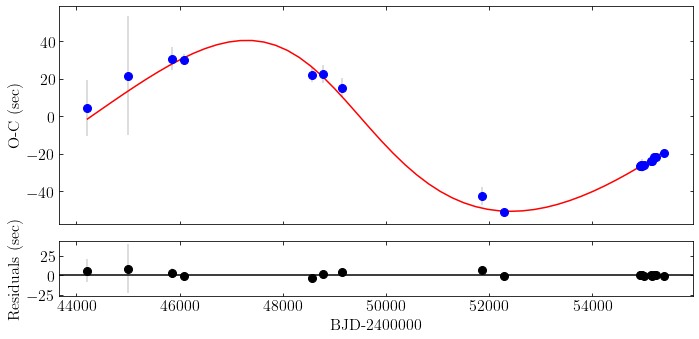

In [12]:
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, sharex=True, sharey=False, figsize=(10, 5), tight_layout=True)
plt.xlabel('BJD-'+str(2400000))

ax0.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')
ax1.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')

ax0.errorbar(x, y, yerr= dy, fmt='o', markersize=8, color='blue', ecolor='lightgray')
ax0.plot(x_line, y_line, '-', color='red')

ax0.set_ylabel('O-C (sec)')
ax1.set_ylabel('Residuals (sec)')


Residual = y-ocfit

ax1.errorbar(x, Residual, yerr= dy, fmt='o', markersize=8, color='black', ecolor='lightgray')

ax1.axhline(y=0, color='black', linestyle='-')

#plt.savefig("2022_Feb_week4_new_ephemeris_sin_fit_Res.jpg", dpi=1000)

plt.show()

In [13]:
N = 700
x_range = [i for i in range(N)]
x_range_a = [i for i in range(N)]
y_range = [i for i in range(len(x_range))]
step=1*100
#step

interporate = []
for i in range(300, N):
    x_range[i] = i*step
    y_range[i] = keplerian_fit(x_range[i], *params)
#    print(x_range[i], y_range[i])
    interporate.append('%0.0f %0.2f %0.5f' %(i, x_range[i], y_range[i]))
    
data_out = interporate
f = open("interporate.out", 'w')
for i in range(len(data_out)):
    f.write(str(data_out[i])+ '\n')
f.close()

In [14]:
InputFile_out = "interporate.out"
Data_out   = np.genfromtxt(InputFile_out)

#Read the wd data: BJD vs. Relative flux
x_range = Data_out[:,1]
y_range = Data_out[:,2]

#print(y_range)

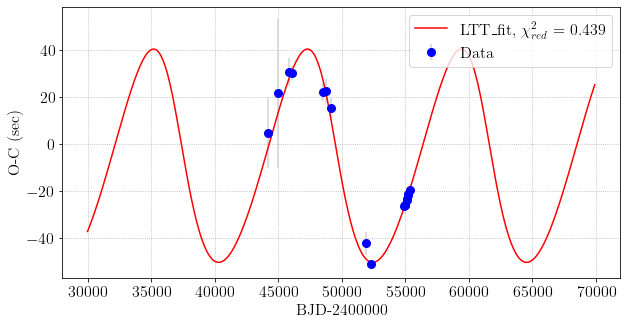

In [15]:
#Plotgraph
fig=plt.figure(figsize=(10, 5))
plt.errorbar(x, y, yerr= dy, fmt='o', markersize=8, color='blue', ecolor='lightgray',label='Data')
# create a line plot for the mapping function
plt.plot(x_range, y_range, '-', color='red',label='LTT\_fit, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq)))
#plt.plot(BJD_time, OC_s_ecc, lw=2, color='black')
#plt.xlim(-6000,6000)
#plt.ylim(-200,200)
#plt.ylim(-40,60)
plt.xlabel('BJD-'+str(2400000))
plt.ylabel('O-C (sec)')
plt.grid(linestyle='dotted')
plt.legend(loc="best")
#####plt.title('O-C diagram: DP Leo')
#output_filename = os.path.splitext(__file__)[0] + '.png'
#plt.savefig("DP_Leo_LTT_fit_weighted_data.jpg", dpi=1000)
plt.show()

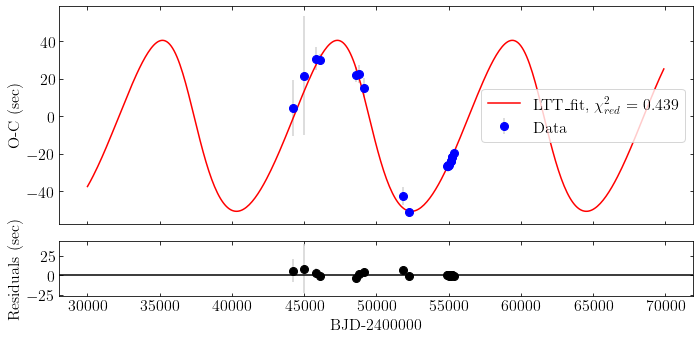

In [16]:
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, sharex=True, sharey=False, figsize=(10, 5), tight_layout=True)
plt.xlabel('BJD-'+str(2400000))

ax0.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')
ax1.tick_params(direction='in', which='both', bottom='on',top='on', right = 'on')

ax0.errorbar(x, y, yerr= dy, fmt='o', markersize=8, color='blue', ecolor='lightgray',label='Data')
ax0.plot(x_range, y_range, '-', color='red',label='LTT\_fit, $\chi_{red}^{2}$ = '+str('%0.3f' %(Reduced_chisq)))

ax0.set_ylabel('O-C (sec)')
ax0.legend(loc="best")

Residual = y-ocfit

ax1.set_ylabel('Residuals (sec)')
ax1.errorbar(x, Residual, yerr= dy, fmt='o', markersize=8, color='black', ecolor='lightgray')
ax1.axhline(y=0, color='black', linestyle='-')

plt.savefig("DP_Leo_LTT_fit_weighted_data_Beuermann_2011_Res.jpg", dpi=1000)

plt.show()